# Tensorflow/Keras Model to classifier VND Currency



![](https://hochiminhcityhighlights.com/wp-content/uploads/2014/05/Vietnames-Dong-500-000-to-10-000.jpg)

Using the dataset, please build the whole VND classifier from end to end please! I'm sure you have learnt enough to complete this project!

Also note that the quality of our dataset is pretty bad on purpose to let you see how even one of the best pre-trained model deal with this dataset.

Let's import a few important libraries to get the things rolling smoothly!

In [3]:
import shutil # copy, move file
import os # miscellaneous operation system interfaces
import pathlib
import random
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

tf.random.set_seed(42) # please feel free to change this seed number
np.random.seed(42) # please feel free to change this seed number

In [23]:
# use this to remove the project folder on internal colab drive to start fresh again
#!rm -rf vnd_currency_project

Let's create the folder for our project in the internal colab drive!

In [4]:
os.mkdir('vnd_currency_project')

Let's create some subfolders to organized our dataset!

In [5]:
os.mkdir('vnd_currency_project/data')
os.mkdir('vnd_currency_project/data/raw')
os.mkdir('vnd_currency_project/data/train')
os.mkdir('vnd_currency_project/data/test')

Here are a few constants to store the important paths to root folder, raw image folder, train image folder and test image folder!

In [9]:
DATA_ROOT_FOLDER = "vnd_currency_project/data"
DATA_RAW_FOLDER = "vnd_currency_project/data/raw"
DATA_TRAIN_FOLDER = "vnd_currency_project/data/train"
DATA_TEST_FOLDER = "vnd_currency_project/data/test"

In [11]:
!pwd

/home/jupyter/Project/vnd_money_classification


Zip file is downloaded to work folder

In [1]:
!wget https://storage.googleapis.com/mle-project/Full_Dataset_VND_Currency.zip

--2020-09-17 19:33:47--  https://storage.googleapis.com/mle-project/Full_Dataset_VND_Currency.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2267095332 (2.1G) [application/zip]
Saving to: ‘Full_Dataset_VND_Currency.zip’

Full_Dataset_VND_Cu 100%[===================>]   2.11G   222MB/s    in 10s     

2020-09-17 19:33:57 (216 MB/s) - ‘Full_Dataset_VND_Currency.zip’ saved [2267095332/2267095332]



In [12]:
raw_zip = 'Full_Dataset_VND_Currency.zip'

In [13]:
shutil.move(raw_zip, DATA_RAW_FOLDER)

'vnd_currency_project/data/raw/Full_Dataset_VND_Currency.zip'

This time, we will unzip the file to internal colab drive using python shutil.unpack_archive instead of unzip command line!

In [14]:
# Full path of  
# the archive file 
filename = "vnd_currency_project/data/raw/Full_Dataset_VND_Currency.zip"
  
# Target directory 
extract_dir = "vnd_currency_project/data/raw/"
  
# Format of archie file 
archive_format = "zip"
  
# Unpack the archive file  
shutil.unpack_archive(filename, extract_dir, archive_format)  
print("Archive file unpacked successfully.") 

Archive file unpacked successfully.


Let's create a function to help us to create empty folder since we need to create folders with label names like 1000,2000,...200000 in train and test folders.

In [15]:
def create_folders(folder_path):
    if os.path.isdir(folder_path):
        shutil.rmtree(folder_path)
        os.mkdir(folder_path)
        print('Removed existing folders and created new folders:', folder_path)
    else:
        os.mkdir(folder_path)
        print('Created new folders:', folder_path)
    
    for folder_name in class_names:
        os.mkdir(os.path.join(folder_path, folder_name))

Let's find how many labels and which label names!

In [16]:
raw_folder =  pathlib.Path(DATA_RAW_FOLDER)
class_names = [str(item.name) for item in raw_folder.glob('*/') if item.is_dir()]
print(class_names)
class_names = np.array(sorted(class_names, key=lambda x: int(x)))

NUM_CLASSES = len(class_names)

all_image_paths = [str(item) for item in raw_folder.glob('*/*') if item.is_file()]
all_image_labels = [str(item.parent.name) for item in raw_folder.glob('*/*') if item.is_file()]

assert len(all_image_paths) == len(all_image_labels)

['100000', '500000', '10000', '5000', '20000', '50000', '200000', '2000', '1000']


Let's create empty folder names with label names in train folder and test folder!

In [17]:
# Create empty train and test folder
create_folders(DATA_TRAIN_FOLDER)
create_folders(DATA_TEST_FOLDER)

Removed existing folders and created new folders: vnd_currency_project/data/train
Removed existing folders and created new folders: vnd_currency_project/data/test


Remember that as a good data scientist, we need to split dataset into training and testing, you can set the ratio to your liking ;)

In [18]:
from sklearn.model_selection import train_test_split

SPLIT_RATIO=0.1

train_image_paths, test_image_paths, train_image_labels, test_image_labels = train_test_split(all_image_paths, all_image_labels, test_size=SPLIT_RATIO, random_state=42)

print('Split data: {} for training and {} for testing'.format(len(train_image_paths), len(test_image_paths)))

Split data: 1541 for training and 172 for testing


In [19]:
assert len(train_image_paths) + len(test_image_paths) == len(all_image_paths)

Let's check out some of random images in our dataset for deep inspection ;)

In [20]:
def open_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def show_batch(image_batch, label_batch):
    '''Show batch of 25 images.
    
    Parameters:
        image_batch: paths to the images, len(image_path) >= 25
        label_batch: labels of the images (str)
    '''
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n].title())
        plt.axis('off')

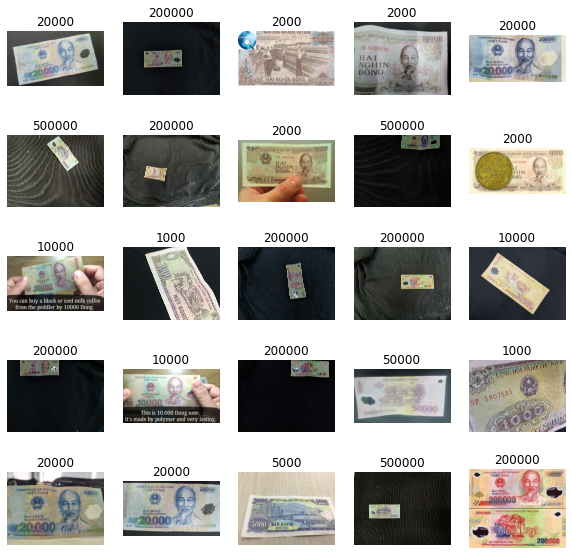

In [21]:
image_batch = [open_image(path)/255 for path in train_image_paths[:25]]
label_batch = train_image_labels[:25]
show_batch(image_batch , label_batch)

Look at those beauties! It seems decent for a small data project!

### Splitting images

* Copy the train images and test images into the approriate folders in the train folder and test folder!

In [22]:
# Move sample images to data/train and data/test
for i in range(len(train_image_paths)):
  shutil.copy(pathlib.Path(train_image_paths[i]), os.path.join(DATA_TRAIN_FOLDER, train_image_paths[i].rsplit('/')[-2], train_image_paths[i].rsplit('/')[-1]))

for i in range(len(test_image_paths)):
  shutil.copy(pathlib.Path(test_image_paths[i]), os.path.join(DATA_TEST_FOLDER, test_image_paths[i].rsplit('/')[-2], test_image_paths[i].rsplit('/')[-1]))


Time to test your code!

In [23]:
print("What we have in our dataset after splitting:", len(train_image_paths),"training images |" , len(test_image_paths),"testing images")

print("What we have in train folder:")
!ls vnd_currency_project/data/train/*/* | wc -l

print("What we have in test folder:")
!ls vnd_currency_project/data/test/*/* | wc -l

What we have in our dataset after splitting: 1541 training images | 172 testing images
What we have in train folder:
1541
What we have in test folder:
172


They should be the same numbers reflecting in the train folder and test folder  then everything will be fine!

**1541 training images and 172 testing images**

### Training your model 

* Please train your model using image augmentation and save the model to h5 file and download it to your laptop!
* You can use any model you want ;)
* Just make sure the input image is 192x192x3 (so it will be consistent with the instructions to build the flask for this project)
* Remember we got 9 classes so the last layers should be dense layer with 9 neurons and activation = "softmax"
* Remember to try different models and analyse as much as you can!


In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [25]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [26]:
train_generator = train_datagen.flow_from_directory(
                        DATA_TRAIN_FOLDER,
                        target_size=(192, 192),
                        batch_size=16,
                        shuffle=True,
                        seed=102,
                        class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
                        DATA_TEST_FOLDER,
                        target_size=(192, 192),
                        batch_size=16,
                        shuffle=False,
                        class_mode='categorical')

Found 1521 images belonging to 9 classes.
Found 169 images belonging to 9 classes.


In [41]:
#First try of DNN
def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (192,192,3))
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
    input = Input(shape=(192, 192, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dropout(0.2)(custom_model)
    predictions = Dense(9, activation='softmax')(custom_model)
    
    return Model(inputs=input, outputs=predictions)

In [28]:
model = model_maker()
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
mobilenet_1.00_192 (Function (None, 6, 6, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 9225      
Total params: 3,238,089
Trainable params: 9,225
Non-trainable params: 3,228,864
_________________________________________________________________


In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(lr=0.01),
              metrics=['acc'])
model.fit(train_generator,
          epochs=15,
          validation_data = validation_generator)

Epoch 1/15
96/96 [==============================] - 136s 1s/step - loss: 1.0733 - acc: 0.7640 - val_loss: 0.3319 - val_acc: 0.9172
Epoch 2/15
96/96 [==============================] - 136s 1s/step - loss: 0.4045 - acc: 0.8974 - val_loss: 0.5167 - val_acc: 0.8935
Epoch 3/15
96/96 [==============================] - 135s 1s/step - loss: 0.3531 - acc: 0.9132 - val_loss: 0.3852 - val_acc: 0.8935
Epoch 4/15
96/96 [==============================] - 135s 1s/step - loss: 0.3132 - acc: 0.9244 - val_loss: 0.4443 - val_acc: 0.9408
Epoch 5/15
96/96 [==============================] - 136s 1s/step - loss: 0.1668 - acc: 0.9467 - val_loss: 0.2189 - val_acc: 0.9231
Epoch 6/15
96/96 [==============================] - 135s 1s/step - loss: 0.2040 - acc: 0.9487 - val_loss: 0.5289 - val_acc: 0.9231
Epoch 7/15
96/96 [==============================] - 136s 1s/step - loss: 0.2399 - acc: 0.9441 - val_loss: 0.4910 - val_acc: 0.9467
Epoch 8/15
96/96 [==============================] - 135s 1s/step - loss: 0.3116 - a

In [31]:
model.save('base.h5')

In [32]:
def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (192,192,3))
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
    input = Input(shape=(192, 192, 3))
    custom_model = base_model(input)
    custom_model = Conv2D(128, 2, activation='relu', strides=(1, 1))(custom_model)
    custom_model = MaxPooling2D()(custom_model)
    custom_model = Conv2D(32, 1, activation='relu', strides=(1, 1))(custom_model)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dropout(0.2)(custom_model)
    predictions = Dense(9, activation='softmax')(custom_model)
    
    return Model(inputs=input, outputs=predictions)

In [33]:
model = model_maker()
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
mobilenet_1.00_192 (Function (None, 6, 6, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 128)         524416    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 32)          4128      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

In [ ]:
lr = 0.1

# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(lr=0.001),
              metrics=['acc'])

# Place tensors on the GPU
with tf.device('/GPU:0'):
    model.fit(train_generator,
        epochs=30,
        validation_data = validation_generator,
        callbacks=[tf.keras.callbacks.EarlyStopping('val_acc', patience=5), tf.keras.callbacks.LearningRateScheduler(scheduler)])

Epoch 1/30
96/96 [==============================] - 135s 1s/step - loss: 0.1076 - acc: 0.9658 - val_loss: 0.3784 - val_acc: 0.9408
Epoch 2/30
96/96 [==============================] - 135s 1s/step - loss: 0.0891 - acc: 0.9691 - val_loss: 0.9278 - val_acc: 0.9172
Epoch 3/30
96/96 [==============================] - 136s 1s/step - loss: 0.0705 - acc: 0.9783 - val_loss: 0.2491 - val_acc: 0.9467
Epoch 4/30
96/96 [==============================] - 136s 1s/step - loss: 0.1046 - acc: 0.9612 - val_loss: 0.3870 - val_acc: 0.9467
Epoch 5/30
96/96 [==============================] - 135s 1s/step - loss: 0.0588 - acc: 0.9816 - val_loss: 0.3410 - val_acc: 0.9408
Epoch 6/30
96/96 [==============================] - 135s 1s/step - loss: 0.0827 - acc: 0.9763 - val_loss: 0.2555 - val_acc: 0.9586
Epoch 7/30
96/96 [==============================] - 135s 1s/step - loss: 0.0662 - acc: 0.9776 - val_loss: 0.7630 - val_acc: 0.9053
Epoch 8/30
96/96 [==============================] - 135s 1s/step - loss: 0.0639 - a

In [44]:
model.save('model.h5')